In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

from gbi_diff.dataset.dataset import SBIDataset
from gbi_diff.model.lit_module import SBI, DiffSBI
from gbi_diff.utils.criterion import SBICriterion

In [62]:
data_train = SBIDataset.from_file("data/two_moons_100000.pt")
data_val = SBIDataset.from_file("data/two_moons_1000.pt")
theta_train = data_train._theta
theta_val = data_val._theta

# guidance_model = DiffSBI.load_from_checkpoint("results/theta_noise/two_moons/lightning_logs/version_2/epoch=34-step=140.ckpt")
guidance_model = SBI.load_from_checkpoint("results/gbi/two_moons/lightning_logs/version_70/epoch=99-step=400.ckpt")

# Train Diffusion Model

In [63]:
def gauss_density(
    x: np.ndarray,
    mean: float = 0,
    std: float = 1,
) -> np.ndarray:
    z = np.sqrt(2 * np.pi * std**2)
    return 1 / z * np.exp(-0.5 * (x - mean) ** 2 / std**2)


def gauss_kl_divergence(
    samples: torch.Tensor,
    n_bins: int = 11,
    samples_per_bin: int = 10,
):
    # true distribution: p = normal gauss / variance preserving schedule
    # incorrect distribution q: diffused samples
    # samples_per_bin: number of samples in a bin
    # sum_s p_s (K log(p_s) - sum_k log(q_{s, k}))
    q, bins = np.histogram(samples, bins=n_bins, density=True)
    
    x = np.linspace(
        bins[0],
        bins[-1],
        n_bins * samples_per_bin,
    )
    p = gauss_density(x, 0, 1)
    q = q[..., None].repeat(samples_per_bin, axis=-1).flatten()
    log_q =  np.where(q > 1e-30, np.log(q), np.log(1e-30))
    log_p =  np.log(p)
    kl_div = p * (log_p - log_q)
    kl_div[p == 0] = 0
    # kl_div[np.isinf(log_q)] == 0
    kl_div = -np.sum(kl_div)
    return kl_div

def noise_sample(sample: torch.Tensor, t: float, beta: float) -> torch.Tensor:
    alpha = 1 - beta
    alpha_bar = alpha**(t + 1)

    sample = torch.normal(np.sqrt(alpha_bar) * sample, (1- alpha_bar))
    return sample

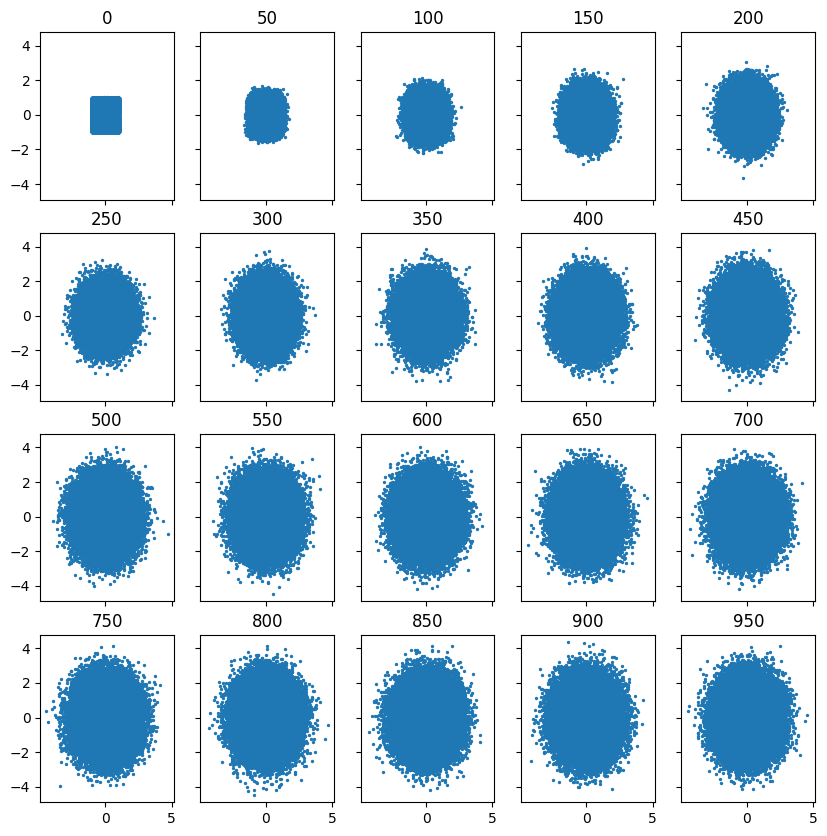

Text(0.5, 0.98, 'Stats over diffusion time')

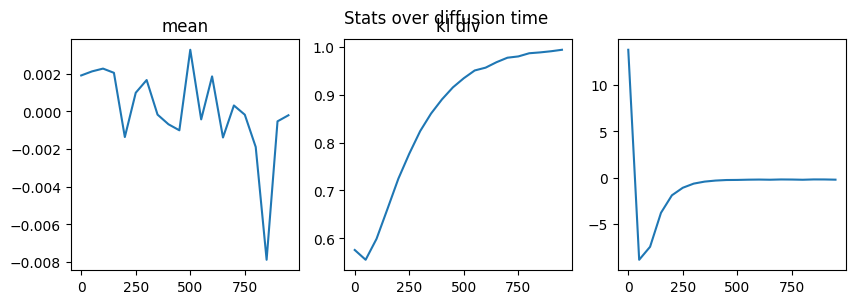

In [64]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(10, 10), sharex=True, sharey=True)
beta = 0.005

mean = []
std = []
kl_div = []
theta = data_train._theta
for t, ax in enumerate(axes.flatten()):
    x = noise_sample(theta, t*50, beta)
    kl_div.append(gauss_kl_divergence(x))
    mean.append(x.mean())
    std.append(x.std())
    ax.scatter(*x.T, s=2)
    ax.set_title(t * 50)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 3))
ax1.plot(np.linspace(0, 950, len(mean)), mean)
ax1.set_title("mean")
ax2.plot(np.linspace(0, 950, len(std)), std)
ax2.set_title("std")
ax3.plot(np.linspace(0, 950, len(kl_div)), kl_div)
ax2.set_title("kl div")
fig.suptitle("Stats over diffusion time")



100%|██████████| 200/200 [00:29<00:00,  6.82it/s]


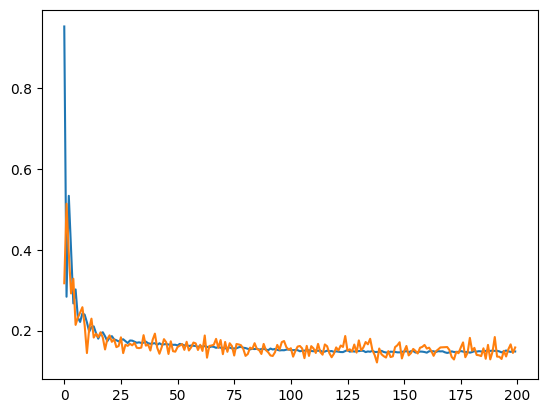

In [65]:
diffusion_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    # nn.Linear(64, 64),
    # nn.SiLU(),
    nn.Linear(64, 2)
)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=0.06)

T = 1000
n_epochs = 200
beta = 0.008

train_loss = []
val_loss = []

theta_mean = theta_train.mean(dim=0)
theta_std = theta_train.std(dim=0)
theta_train_normed = (theta_train - theta_mean) / theta_std
theta_val_normed = (theta_val - theta_mean) / theta_std

for epoch in tqdm(range(n_epochs)):
    alpha = 1 - beta

    # sample diffusion process
    t = np.random.choice(T, size=len(theta_train_normed))
    alpha_bar = alpha**(t + 1)
    t = torch.from_numpy(t)
    alpha_bar = torch.from_numpy(alpha_bar)[:, None]

    y_t = torch.normal(0, 1, size=(theta_train_normed.shape))
    x_t = np.sqrt(alpha_bar) * theta_train_normed + (1- alpha_bar) * y_t
    
    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)
    
    loss = criterion.forward(pred, y_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # validate model
    diffusion_model.eval()
    t = np.random.choice(T, size=len(theta_val_normed))
    alpha_bar = alpha**(t + 1)
    t = torch.from_numpy(t)
    alpha_bar = torch.from_numpy(alpha_bar)[:, None]

    y_t = torch.normal(0, 1, size=(theta_val_normed.shape))
    x_t = np.sqrt(alpha_bar) * theta_val_normed + (1- alpha_bar) * y_t
    
    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)
    loss = criterion.forward(pred, y_t)
    
    val_loss.append(loss.item())
    diffusion_model.train()

plt.plot(train_loss)
plt.plot(val_loss)

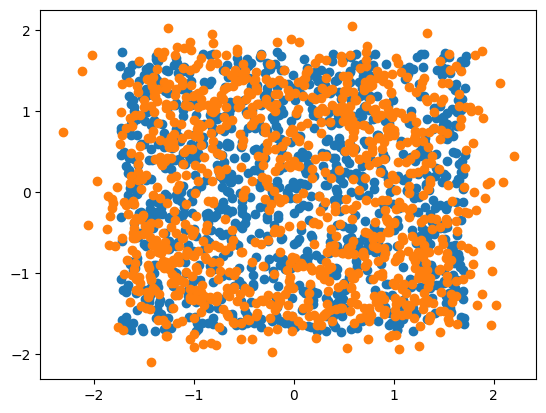

In [66]:
sample_size = 1000

x_t = torch.normal(0, 1, size=(sample_size, 2), requires_grad=True)
plt.scatter(*theta_val_normed.detach().numpy().T)

for t in reversed(range(T)):
    # t += 1
    alpha = 1 - beta
    alpha_bar = alpha ** (t + 1)
    t = torch.tensor([t])[None].repeat(sample_size, 1)
    inp = torch.cat([x_t, t / T], dim=1).float()
    

    # sigma_t = np.sqrt((1 - alpha ** t) / 1- alpha_bar * beta) 
    sigma_t = np.sqrt(beta) 
    z = torch.normal(0, 1, size=(x_t.shape))
    x_t = (
        1 / np.sqrt(alpha)
        * (x_t - (1 - alpha) / np.sqrt(1 - alpha_bar) * diffusion_model.forward(inp)) # plus or minus
        + sigma_t * z
    )

plt.scatter(*x_t.detach().numpy().T)

1000it [00:10, 94.83it/s]


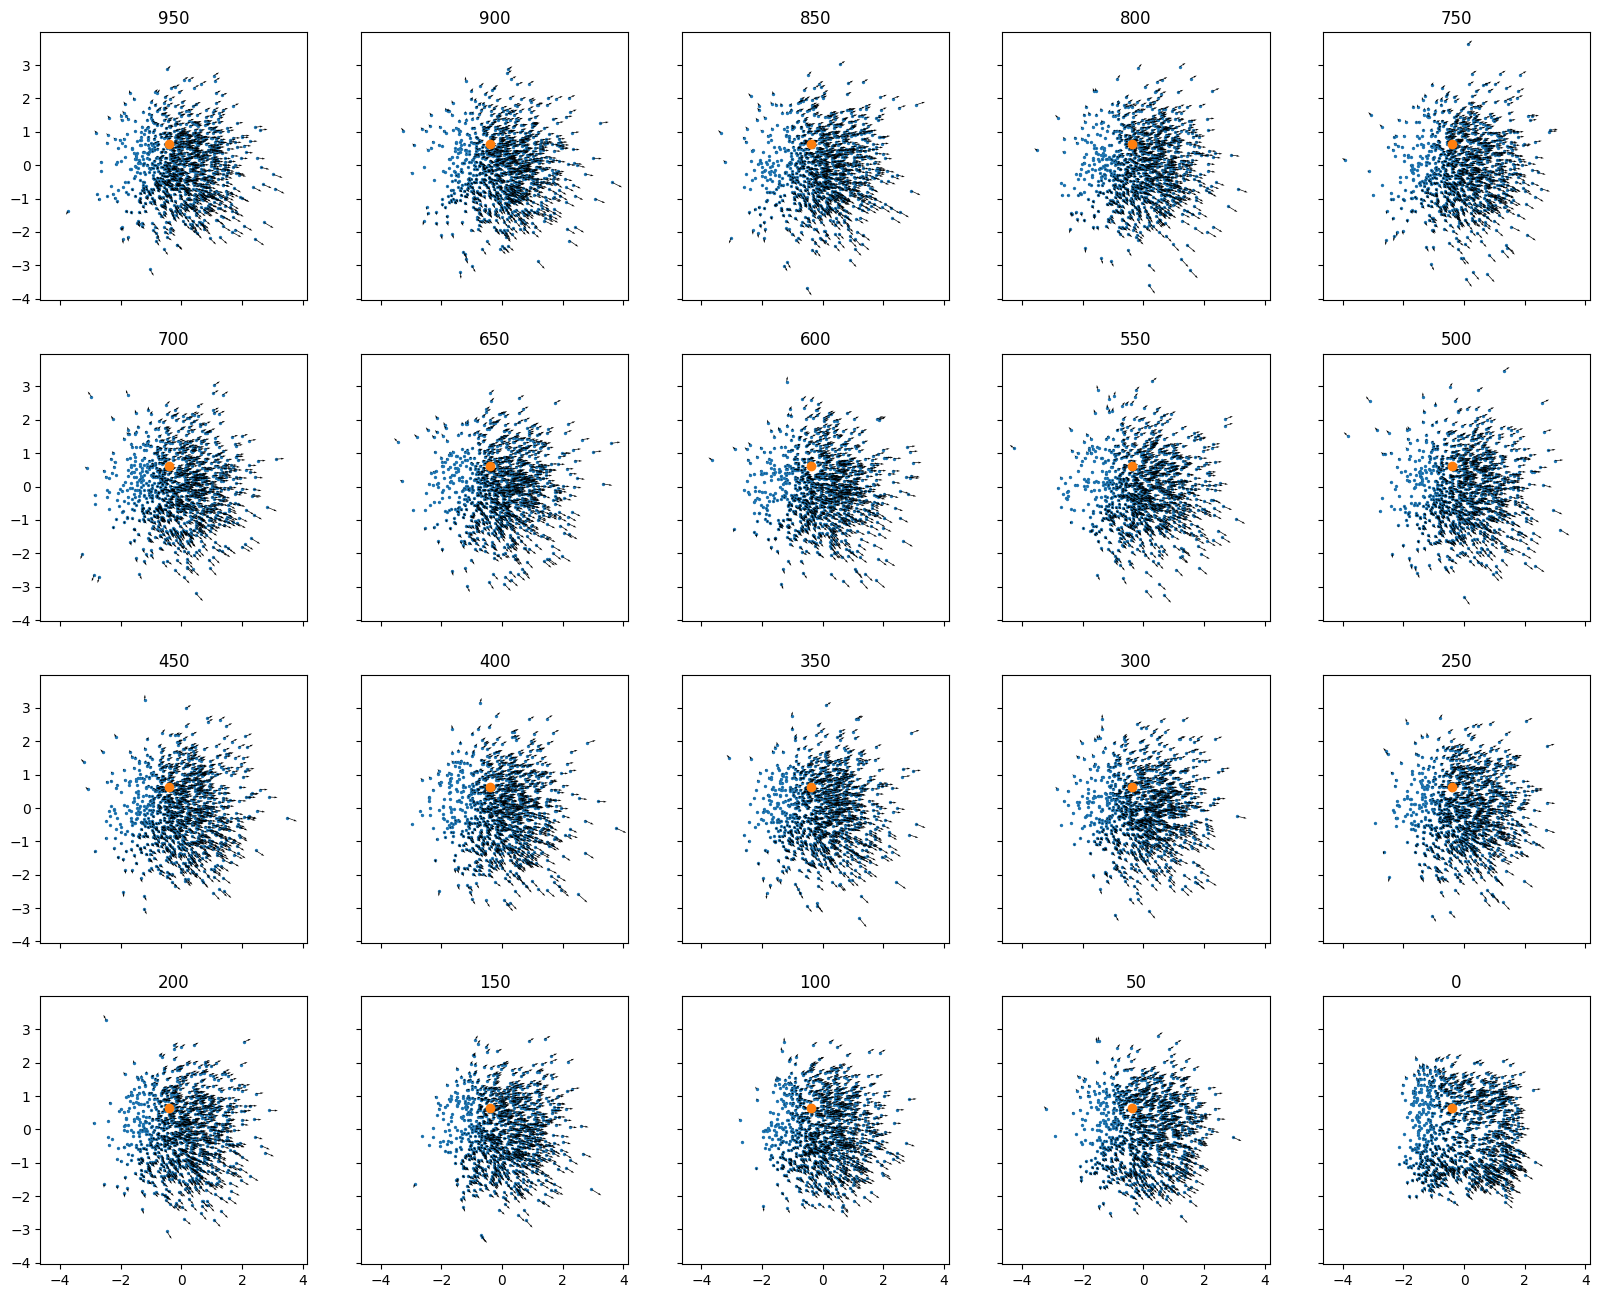

In [71]:
sample_size = 1000

x_t = torch.normal(0, 1, size=(sample_size, 2), requires_grad=True)

label = torch.zeros((sample_size, 2))
label[:, 1] = 1

guidance_criterion = SBICriterion()
true_theta, condition, _ = data_train[0]
condition = condition[None, None].repeat((sample_size, 1, 1))  # batch_size, n_target, feature_dim

fig, axs = plt.subplots(ncols=5,nrows=4, sharex=True, sharey=True, figsize=(20, 16))
axs = axs.flatten()
skip = T // len(axs)

for t_idx in tqdm(reversed(range(T))):
#           t_idx += 1

    alpha = 1 - beta
    alpha_bar = alpha ** (t + 1)

    t = torch.tensor([t_idx])[None].repeat(sample_size, 1)
    inp = torch.cat([x_t.detach(), t / T], dim=1).float()
    diffusion_step = diffusion_model.forward(inp.detach())

    x_t.requires_grad_(True)
    score = guidance_model.forward(x_t * theta_std + theta_std, condition)
    loss = guidance_criterion.forward(score, condition[:, 0], condition)
    classifier_grad = torch.autograd.grad(
        outputs=loss, inputs=x_t, grad_outputs=torch.ones_like(loss)
    )
    classifier_grad = classifier_grad[0]

    sigma_t = np.sqrt(beta)
    z = torch.normal(0, 1, size=(x_t.shape))
    x_t = (
        1
        / np.sqrt(alpha)
        * (
            x_t
    - (1 - alpha) / np.sqrt(1 - alpha_bar) * (diffusion_step -  1000 * classifier_grad)
        )  # plus or minus
        + sigma_t * z
    )

    if t_idx % skip == 0:
        plot_idx = T // skip - 1 - t_idx // skip
        axs[plot_idx].scatter(
            *x_t.detach().numpy().T,
            # c=torch.softmax(class_pred, dim=1).detach().numpy()[:, 1]
            s=2
        )
        axs[plot_idx].quiver(
            *x_t.detach().numpy().T, *classifier_grad.detach().numpy().T
        )
        axs[plot_idx].set_title(t_idx)
        axs[plot_idx].scatter(*true_theta)
#  axs[plot_idx].scatter(*x_val[y_val[:, 0] == 1].T, s=2)
        #  axs[plot_idx].scatter(*x_val[y_val[:, 1] == 1].T, s=2)
        

# plt.show()
# x_t.requires_grad_(True)
# class_pred = classifier(x_t)
# loss = classifier_criterion(class_pred, label)
# classifier_grad = torch.autograd.grad(
#     outputs=loss, inputs=x_t, grad_outputs=torch.ones_like(loss)
# )
#     
# plt.scatter(
#     *x_t.detach().numpy().T,
#     # c=torch.softmax(class_pred, dim=1).detach().numpy()[:, 1]
# )
# plt.quiver(
#     *x_t.detach().numpy().T, *classifier_grad[0].detach().numpy().T
# )
# 
# label